# Pgnet Model with MVN Resampling

### TODO

- Move noDNA model to experimental
- Compile results for different models
- For pgnet, simulate with high n_res (10), but for inference can reduce 

- Simulate with small `dt`, inference with `dt` from Wilkinson paper. Do this for no DNA model

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import models
import optax
from functools import partial
import projplot as pjp

import warnings
warnings.filterwarnings('ignore')

In [2]:
# bridge
@jax.partial(jax.jit, static_argnums=(1,2, ))
def pf_neg_loglik_bridge(theta, resampler = pf.resample_mvn):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=pgnet_dna_bridge, 
        y_meas=y_meas, 
        n_particles=n_particles, key=key,
        resampler = resampler)
    return -pf.particle_loglik(temp['logw'])

# @jax.partial(jax.jit, static_argnums=(1,2, 3, 4, ))
def particle_neg_loglik_mvn(theta, key, n_particles, y_meas, model):
    ret = pf.particle_filter(model, key, y_meas, theta, 
                             n_particles, 
                             resampler=pf.resample_mvn)
    return -pf.particle_loglik(ret['logw'])

# @jax.partial(jax.jit, static_argnums=(1,2, 3, 4, ))
def particle_neg_loglik(theta, key, n_particles, y_meas, model):
    ret = pf.particle_filter(model, key, y_meas, theta, 
                             n_particles)
    return -pf.particle_loglik(ret['logw'])

def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    loglik_value, params_update = jax.value_and_grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates), loglik_value


def simple_grad_descent (model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, key=1, mask=None, verbose = False):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    losses = []
    thetas = []
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        losses.append(loglik_value)
        thetas.append(theta)
        if verbose: 
            print(f"Log-likelihood: {loglik_value}")
    return theta, losses, thetas


def stoch_opt(model, theta, grad_fun, y_meas, n_particles=100, 
              n_iter=10, learning_rate=0.01, key=1, mask=None):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    keys = random.split(key, n_iter)
    losses = []
    thetas = []
    for subkey in keys:
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas

## No DNA

D1: 50, dt=1  
D4: n_obs = 100, dt = .5  
D5: n_obs = 500, dt = .1

In [ ]:
key = random.PRNGKey(0)

_theta = jnp.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
_noise = 0.005 
tau = jnp.array([1,1,1]) * _noise

DNA_init = jnp.array([5.])

theta = jnp.concatenate([_theta, tau, DNA_init])
dt = 0.1
n_res = 1
n_obs = 75 # 50 

pgnet_dna = models.PGNETModelNoDNA(dt, n_res)
pgnet_dna_bridge = models.PGNETModelNoDNA(dt, n_res, bootstrap = False)

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_dna, subkey, n_obs, x_init, theta)

In [ ]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [ ]:
theta_lims = np.array([[0.05, 0.15], 
                       [0.5,1.], 
                       [0.1, 0.55],
                       [0.05, 0.45], 
                       [0.05, 0.25], 
                       [0.7, 1.], 
                       [0.01, 0.5], 
                       [0.01, 0.25],
                       [_noise, _noise], 
                       [_noise, _noise], 
                       [_noise, _noise], 
                       [5., 5.]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]

In [ ]:
n_particles = 250

plot_mvn = pf.proj_data(
    fun = lambda x: pf_neg_loglik_bridge(x), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = pf.proj_data(
    fun = lambda x: pf_neg_loglik_bridge(x, resampler = pf.resample_multinomial),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title=f"PGNET, n_res={n_res}")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

In [ ]:
# Fix parameters and run both filters with these: 
init_params = theta
n_particles = 250
n_iter = 50
learning_rate = 1e-3

mvn_params, mvn_losses, mvn_steps = simple_grad_descent(
    key = key,
    model = pgnet_dna_bridge,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=jnp.concatenate([np.ones(8), np.zeros(4)]),
    verbose = False
)

print("Estimated params: ", mvn_params)

In [ ]:
grid = sns.relplot(
    data=plot_mvn, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="PGNET - Bridge Proposal, MVN Resampling")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(mvn_params[ind], color='red', lw = 0.75);

## DNA Observed

In [7]:
key = random.PRNGKey(0)

theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
_noise = 0.5
tau = np.array([1,1,1,1]) * _noise

theta = np.concatenate([theta, tau])
dt = 0.1
n_res = 1
n_obs = 50

pgnet_bridge = models.PGNETModel(dt, n_res, bootstrap=False)

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_bridge, subkey, n_obs, x_init, theta)

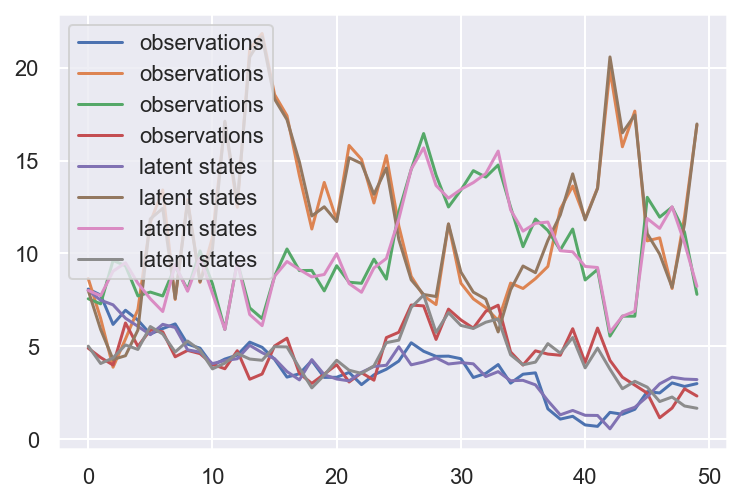

In [8]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [9]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

In [10]:
theta_lims = np.array([[0, 0.5], 
                       [0,1], 
                       [0, 1],
                       [0, 1], 
                       [0, 1], 
                       [0.5, 1], 
                       [0, 0.5], 
                       [0, 0.5],
                       [0.01, 2], 
                       [0.01, 2], 
                       [0.01, 2], 
                       [0.01, 2]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]

In [11]:
# log-likelihood for Lotvol model with MVN resamplings
@jax.partial(jax.jit, static_argnums=(1,2, ))
def pf_neg_loglik(theta, model = pgnet_bridge, resampler = pf.resample_mvn):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, key=key,
        resampler = resampler)
    return -pf.particle_loglik(temp['logw'])

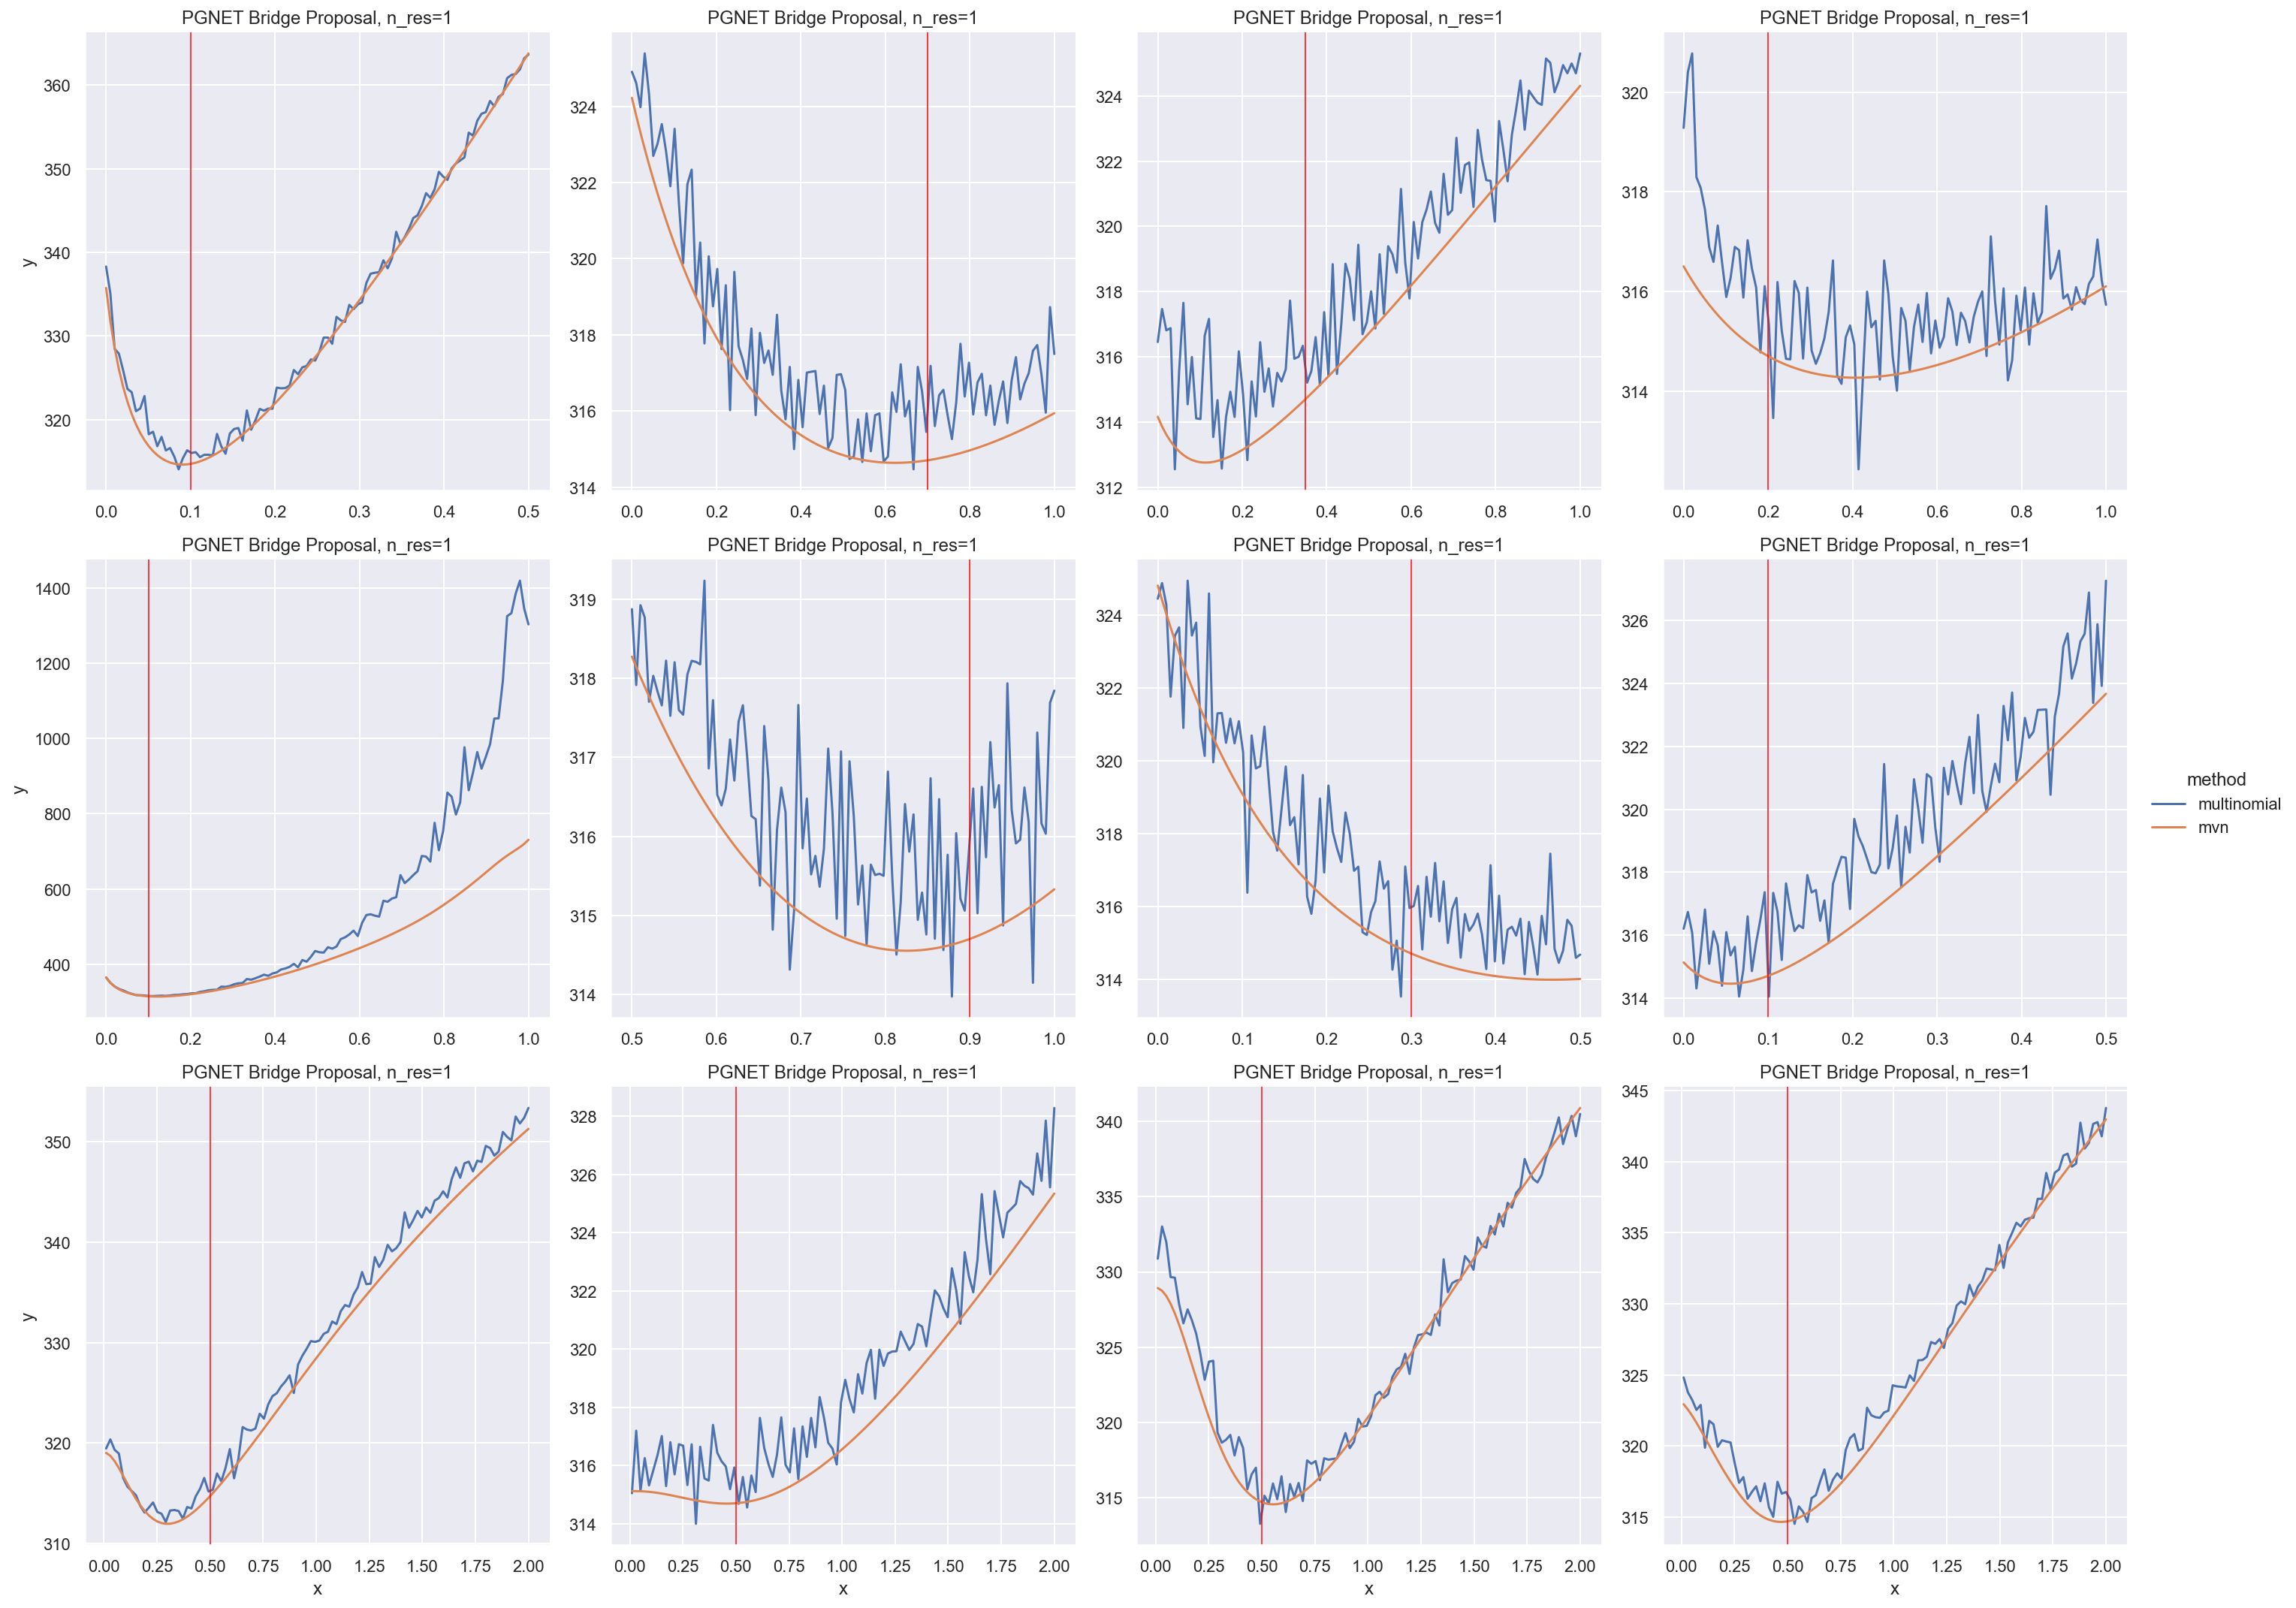

In [12]:
n_particles = 250

plot_mvn = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x), 
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_multinom = pf.proj_data(
    fun = lambda x: pf_neg_loglik(x, resampler = pf.resample_multinomial),
    theta = theta, 
    theta_lims = theta_lims, 
    theta_names = theta_names)

plot_mvn["method"] = "mvn"
plot_multinom["method"] = "multinomial"
df = pd.concat([plot_multinom, plot_mvn]).reset_index(drop=True)

grid = sns.relplot(
    data=df, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title=f"PGNET Bridge Proposal, n_res={n_res}")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.75);

In [21]:
init_params = jnp.array([0.05, 0.5, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1, 1., 1., .8, .8])
# init_params = theta
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [0.1  0.7  0.35 0.2  0.1  0.9  0.3  0.1  0.5  0.5  0.5  0.5 ]
Initial params:  [0.05 0.5  0.35 0.2  0.1  0.9  0.3  0.1  1.   1.   0.8  0.8 ]


In [22]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 100
learning_rate = 1e-3

start = time.time()
mvn_params, mvn_losses, mvn_steps = simple_grad_descent(
    key = key,
    model = pgnet_bridge,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params)),
    verbose = False
)

print("Time: ", time.time() - start)
print("Estimated params: ", mvn_params)

Time:  64.93716192245483
Estimated params:  [5.9999943e-02 4.0000129e-01 2.5000128e-01 2.9999873e-01 1.2799983e-01
 8.2800090e-01 3.9999872e-01 5.9045851e-07 9.0000129e-01 9.0000129e-01
 7.0000130e-01 7.0000130e-01]


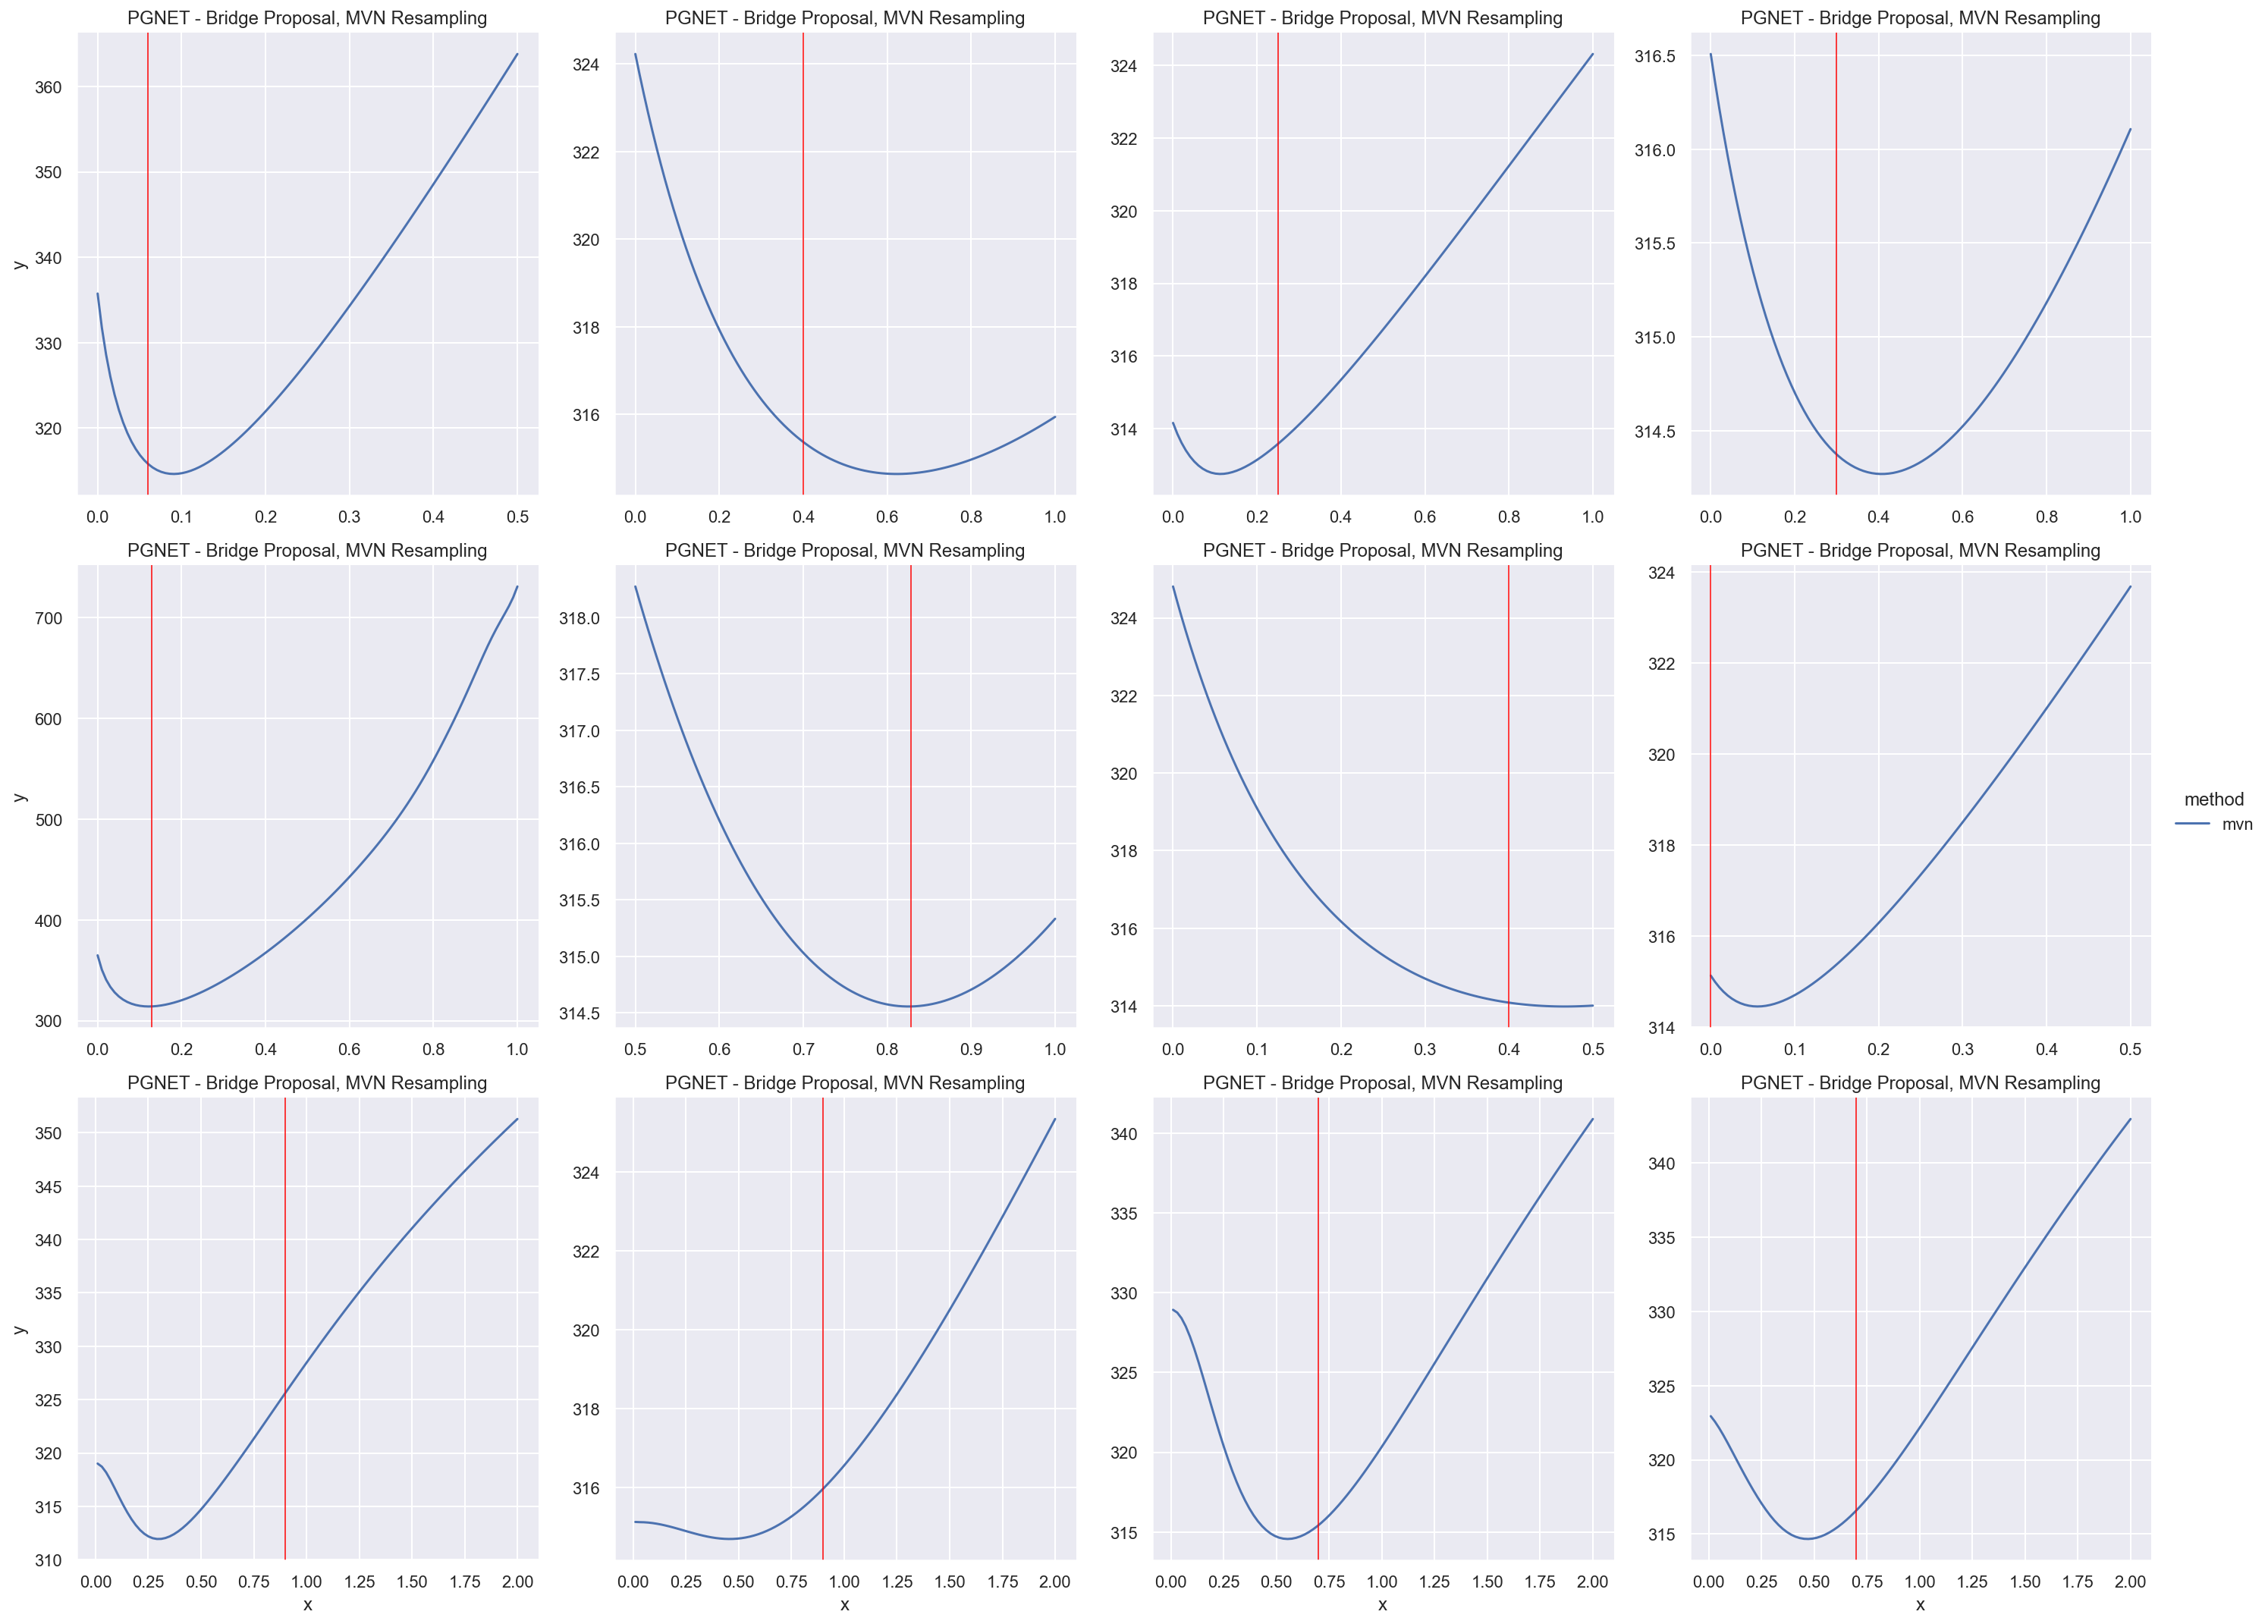

In [23]:
grid = sns.relplot(
    data=plot_mvn, 
    kind="line",
    hue = "method",
    x="x", y="y", 
    col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
).set(title="PGNET - Bridge Proposal, MVN Resampling")

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(mvn_params[ind], color='red', lw = 0.75);

In [16]:
# check that we have minimized the negative log-lik: Hessian should be positive definite: 
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik_mvn))
hess = hessian_fn(
    mvn_params,
    key,
    n_particles=100,
    y_meas=y_meas,
    model=pgnet_bridge)

print("Is positive definite?: ", jnp.all(jnp.linalg.eigvals(hess) >= 0))

Is positive definite?:  True


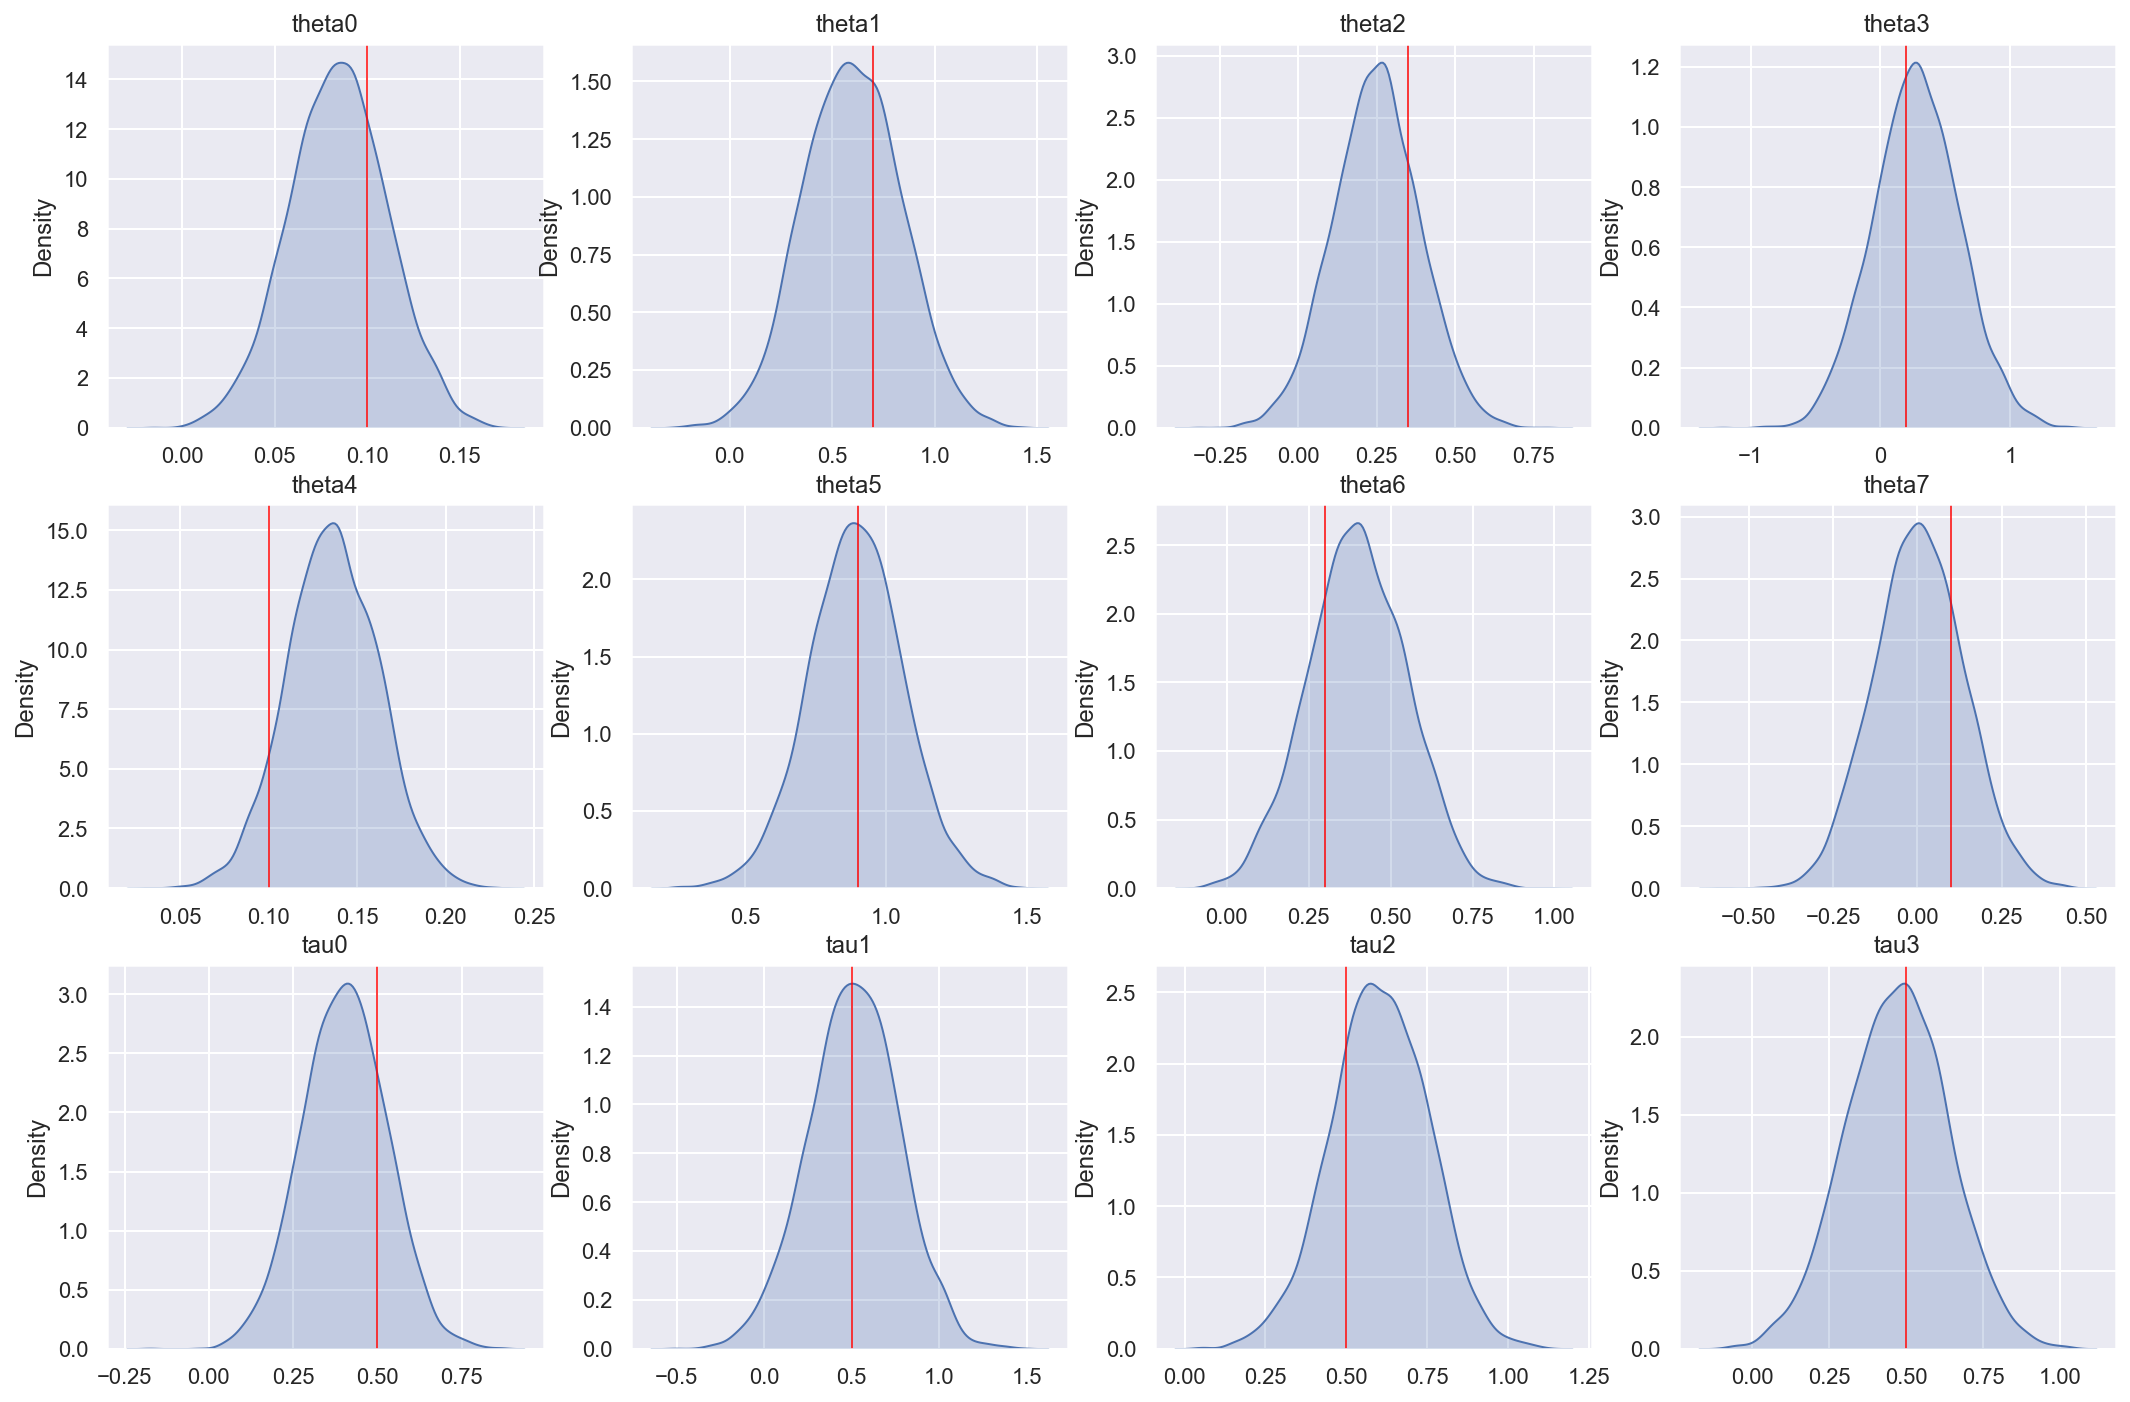

In [19]:
# var = jnp.linalg.inv(hess)
# mle_samples = random.multivariate_normal(key=key, mean=mvn_params, cov=var, shape=(5_000, ))

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show();

## Troubleshooting 

D1: 50, dt=1  
D4: n_obs = 100, dt = .5  
D5: n_obs = 500, dt = .1

- Figure out where this is happening. First the x_state goes to Inf, then y_meas. Figure out why x_state goes to Inf. 


- Sometimes one latent variable goes negative, which makes the diffusion negative definite
- 

In [ ]:
from jax.config import config

config.update("jax_enable_x64", False)

In [ ]:
key = random.PRNGKey(0)

theta = jnp.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
_noise = jnp.log(4.) #0.005
tau = jnp.array([1,1,1]) * _noise

DNA_init = jnp.array([5.])

theta = jnp.concatenate([theta, tau, DNA_init])
dt = 1
n_res = 1
n_obs = 50 # 50 

# pgnet_dna = models.PGNETModelNoDNA(dt, n_res)
pgnet_dna = models.PGNETModel(dt, n_res)
pgnet_dna_bridge = models.PGNETModelNoDNA(dt, n_res, bootstrap = False)

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_dna, subkey, n_obs, x_init, theta)

In [ ]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [ ]:
f_p = jnp.array([ 1.1612988, -0.7831085, 49.38876  ,  1.6880879])
print(jnp.outer(f_p, f_p))

In [ ]:
x_state